In [92]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
from selenium.webdriver import ActionChains
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException
from webdriver_manager.chrome import ChromeDriverManager
import time

from scraping_cleaning_data import import_data, get_prices, filter_holofoil_data

In [2]:
df1=import_data()
df=filter_holofoil_data(df1, 20)
df

,id,name,rarity,collection,series,holofoil_price,reverse_holofoil_price,url,release_date,nationalPokedexNumbers,artist
8,ex12-1,Aerodactyl,Rare Holo,Legend Maker,EX,21.23,32.65,https://prices.pokemontcg.io/tcgplayer/ex12-1,2006/02/01,[142],Hajime Kusajima
9,ex3-1,Absol,Rare Holo,Dragon,EX,40.17,22.89,https://prices.pokemontcg.io/tcgplayer/ex3-1,2003/11/24,[359],Naoyo Kimura
12,base4-1,Alakazam,Rare Holo,Base Set 2,Base,28.16,NaN,https://prices.pokemontcg.io/tcgplayer/base4-1,2000/02/24,[65],Ken Sugimori
13,hgss1-1,Arcanine,Rare Holo,HeartGold & SoulSilver,HeartGold & SoulSilver,22.70,13.36,https://prices.pokemontcg.io/tcgplayer/hgss1-1,2010/02/10,[59],Naoki Saito
14,ex11-1,Beedrill δ,Rare Holo,Delta Species,EX,20.74,22.07,https://prices.pokemontcg.io/tcgplayer/ex11-1,2005/10/31,[15],Masakazu Fukuda
...,...,...,...,...,...,...,...,...,...,...,...
951,dp3-14,Lugia,Rare Holo,Secret Wonders,Diamond & Pearl,61.04,30.29,https://prices.pokemontcg.io/tcgplayer/dp3-14,2007/11/01,[249],Kazuyuki Kano
965,ex15-2,Feraligatr δ,Rare Holo,Dragon Frontiers,EX,18.56,47.57,https://prices.pokemontcg.io/tcgplayer/ex15-2,2006/11/01,[160],Kouki Saitou
975,base1-11,Nidoking,Rare Holo,Base,Base,27.74,NaN,https://prices.pokemontcg.io/tcgplayer/base1-11,1999/01/09,[34],Ken Sugimori
982,ex10-11,Poliwrath,Rare Holo,Unseen Forces,EX,16.42,22.12,https://prices.pokemontcg.io/tcgplayer/ex10-11,2005/08/01,[62],Hajime Kusajima


In [4]:
website="https://prices.pokemontcg.io/tcgplayer/base4-1"

In [6]:
def setup_driver():
    service = Service(ChromeDriverManager().install())
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--window-size=1920,1080")  # Définir une taille d'écran standard
    #chrome_options.add_argument("--disable-gpu")
    return webdriver.Chrome(service=service, options=chrome_options)

In [17]:
def wait_and_click_button(driver, wait):
    try:
        one_year_button = wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-v-0177b97d][class*="charts-item"]:last-child'))
        )
        
        driver.execute_script("arguments[0].scrollIntoView(true);", one_year_button)
        time.sleep(1) 
        
        try:
            one_year_button.click()
        except ElementClickInterceptedException:
            # Si le clic direct échoue, essayer avec JavaScript
            driver.execute_script("arguments[0].click();", one_year_button)
        
        print("Clic sur le bouton 1Y effectué avec succès!")
        return True
        
    except TimeoutException:
        print("Le bouton 1Y n'a pas été trouvé avec le premier sélecteur, essai avec alternative...")
        try:
            # Essayer avec un sélecteur alternatif
            one_year_button = wait.until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'charts-item') and contains(text(), '1Y')]"))
            )
            driver.execute_script("arguments[0].click();", one_year_button)
            print("Clic sur le bouton 1Y effectué avec succès (méthode alternative)!")
            return True
        except TimeoutException:
            print("Impossible de trouver le bouton 1Y même avec le sélecteur alternatif.")
            return False

In [58]:

def get_chart_data(driver, wait):
    try:
        # Attendre que le graphique soit mis à jour
        chart = wait.until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.martech-charts-history[data-testid='History']"))
        )
        
        time.sleep(2)
        
        return chart.get_attribute('outerHTML')
    except TimeoutException:
        print("Impossible de trouver le graphique après le clic.")
        return None

In [93]:
def plot_price_quantity_variation(price_history):
    # Création de la figure et des axes
    fig, ax1 = plt.subplots(figsize=(15, 7))
    
    # Configuration de l'axe des prix (gauche)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Prix ($)', color='blue')
    ax1.plot(df.index, df['price'], color='blue', marker='o', linewidth=1.5, 
             label='Prix', markersize=4)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Ajout de la ligne moyenne
    mean_price = df['price'].mean()
    ax1.axhline(y=mean_price, color='blue', linestyle='--', alpha=0.3)
    
    # Configuration de l'axe des quantités (droite)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Quantité vendue', color='orange')
    ax2.bar(df.index, df['quantity_sold'], color='orange', alpha=0.3, 
            label='Quantité vendue')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Rotation des dates
    plt.xticks(rotation=45)
    
    # Titre
    plt.title('Variation du Prix et Quantité Vendue de la Carte Pokémon')
    
    # Légendes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

In [33]:
def extract_html_code_1Y(website):
    driver = setup_driver()
    wait = WebDriverWait(driver, 20)
    html_content = None  # Initialiser la variable pour éviter les erreurs si aucune donnée n'est récupérée

    try:
        driver.get(website)
        print("Page chargée avec succès")
        wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        
        # Étape 1 : Cliquer sur le bouton 1Y
        if wait_and_click_button(driver, wait):
            print("Clic sur le bouton 1Y réussi.")
            
            # Étape 2 : Cliquer sur le bouton "View More Data"
            if click_view_more_data(driver, wait):
                print("Clic sur le bouton View More Data réussi.")
                
                # Étape 3 : Récupérer le contenu HTML des données du graphique
                html_content = get_chart_data(driver, wait)
                if html_content:
                    print("Contenu HTML récupéré avec succès!")
                else:
                    print("Échec de la récupération du contenu HTML.")
            else:
                print("Échec du clic sur le bouton View More Data.")
        else:
            print("Échec du clic sur le bouton 1Y.")

    except Exception as e:
        print(f"Une erreur est survenue : {str(e)}")
        
    finally:
        driver.quit()
        print("Navigation terminée - Driver fermé.")
    
    return html_content


In [35]:
html_content=extract_html_code_1Y(website)
html_content

KeyboardInterrupt: 

In [40]:
def test_button_click(driver, wait, selector, by=By.CSS_SELECTOR):
    try:
        # Attendre que l'élément soit présent
        element = wait.until(EC.presence_of_element_located((by, selector)))
        
        # Scroll avec JavaScript pour centrer l'élément
        driver.execute_script("""
            arguments[0].scrollIntoView({
                block: 'center',
                inline: 'center'
            });
        """, element)
        
        # Attendre que l'élément soit cliquable
        wait.until(EC.element_to_be_clickable((by, selector)))
        
        # Cliquer avec JavaScript pour éviter les problèmes de viewport
        driver.execute_script("arguments[0].click();", element)
        return True
        
    except Exception as e:
        print(f"Échec du clic pour {selector}: {str(e)}")
        return False

In [27]:
def setup_and_click_buttons(website):
    driver = setup_driver()
    wait = WebDriverWait(driver, 25)

    try:
        # Charger la page
        driver.get(website)
        print("Page chargée.")

        # Définition des sélecteurs
        selectors = {
            'view_more': ('CSS_SELECTOR', 'div.modal__activator[role="button"]'),
            'filter_sales': ('CSS_SELECTOR', 'button.sales-history-snapshot__show-filters'),
            'near_mint': ('XPATH', '//label[span[text()="Near Mint"]]')
        }

        # Clic séquentiel sur chaque bouton
        for button_name, (selector_type, selector) in selectors.items():
            by_type = By.CSS_SELECTOR if selector_type == 'CSS_SELECTOR' else By.XPATH
            if not test_button_click(driver, wait, selector, by=by_type):
                print(f'Échec du clic sur {button_name}')
                return False
            print(f"Test réussi : Clic effectué sur {button_name}")
            time.sleep(2)  # Petit délai entre les clics

        return True

    except Exception as e:
        print(f"Une erreur est survenue : {str(e)}")
        return False

    finally:
        driver.quit()

In [28]:
html_content=setup_and_click_buttons(website)

Page chargée.
Test réussi : Clic effectué sur view_more
Test réussi : Clic effectué sur filter_sales
Test réussi : Clic effectué sur near_mint


In [45]:
def extract_html_code_1Y_NM(website):
    driver = setup_driver()
    wait = WebDriverWait(driver, 25)
    
    try:
        driver.get(website)
        print("Page chargée avec succès")
        
        wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        
        # Séquence de clics avec les sélecteurs appropriés
        click_sequence = [
            ('CSS_SELECTOR', 'div.modal__activator[role="button"]'),
            ('CSS_SELECTOR', 'button.sales-history-snapshot__show-filters'),
            ('XPATH', '//label[span[text()="Near Mint"]]'),
            ('CSS_SELECTOR', 'button[data-v-0177b97d][class*="charts-item"]:last-child')  # Bouton 1Y
        ]
        
        for selector_type, selector in click_sequence:
            by_type = By.CSS_SELECTOR if selector_type == 'CSS_SELECTOR' else By.XPATH
            if not test_button_click(driver, wait, selector, by=by_type):
                print(f"Échec du clic pour le sélecteur: {selector}")
                return None
                
        html_content = get_chart_data(driver, wait)
        if html_content:
            print("Contenu HTML récupéré avec succès")
            return html_content
            
        print("Échec de la récupération du contenu HTML")
        return None

    except Exception as e:
        print(f"Une erreur est survenue : {str(e)}")
        return None
        
    finally:
        driver.quit()
        print("Navigation terminée - Driver fermé")

In [59]:
test=extract_html_code_1Y_NM(website)

Page chargée avec succès
Contenu HTML récupéré avec succès
Navigation terminée - Driver fermé


In [60]:
test

'<div data-v-85056b11="" class="martech-charts-history" data-testid="History"><div data-v-85056b11="" class="martech-charts-content"><!----><div data-v-85056b11="" class="martech-charts-header-controls"><div data-v-eefc313a="" data-v-85056b11="" class="charts-header" data-testid="History__Default"><div data-v-eefc313a="" class="charts-row"><div data-v-eefc313a="" class="charts-color" style="background-color: rgb(242, 249, 255);"><div data-v-eefc313a="" class="charts-group" style="color: rgb(8, 53, 219);"><svg data-v-eefc313a="" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 40 28" class="graph-icon"><path d="M20.5 28c-1.1 0-2-.9-2-2V3h-7v10.5c0 1.1-.9 2-2 2h-9c-.28 0-.5-.22-.5-.5v-2c0-.28.22-.5.5-.5h8V2c0-1.1.9-2 2-2h9c1.1 0 2 .9 2 2v23h7V14.5c0-1.1.9-2 2-2h9c.28 0 .5.22.5.5v2c0 .28-.22.5-.5.5h-8V26c0 1.1-.9 2-2 2h-9Z" fill="currentColor"></path></svg><div data-v-eefc313a="" class="charts-title">Near Mint Holofoil </div></div><div data-v-eefc313a="" class="charts-price">$28.16</div></

In [62]:
prices=extract_price_history(test)
#plot_price_quantity_variation(prices)
prices

,2024-12-05,2024-12-12,2024-12-19,2024-12-26,2024-01-02,2024-01-09,2024-01-16,2024-01-23,2024-01-30,2024-02-06,...,2024-09-24,2024-10-01,2024-10-08,2024-10-15,2024-10-22,2024-10-29,2024-11-05,2024-11-12,2024-11-19,2024-11-26
,2024-12-11,2024-12-18,2024-12-25,2024-01-01,2024-01-08,2024-01-15,2024-01-22,2024-01-29,2024-02-05,2024-02-12,...,2024-09-30,2024-10-07,2024-10-14,2024-10-21,2024-10-28,2024-11-04,2024-11-11,2024-11-18,2024-11-25,2024-12-02
price,25.18,25.43,24.09,24.11,23.73,23.28,23.59,23.84,23.74,23.78,...,26.28,26.48,26.5,26.74,26.71,27.71,28.31,28.25,28.16,28.16
quantity_sold,0.00,1.00,5.00,1.00,1.00,4.00,1.00,4.00,2.00,0.00,...,4.00,1.00,1.0,3.00,2.00,4.00,4.00,2.00,2.00,0.00


In [75]:

def extract_price_history(html_content):
    """
    Extrait l'historique des prix et des quantités vendues d'un contenu HTML,
    avec les dates sous forme de périodes 'date1 to date2'.
    
    Args:
        html_content (str): Le contenu HTML contenant les informations des prix et quantités.
    
    Returns:
        dict: Un dictionnaire avec les dates (début et fin de la période), les prix et les quantités vendues.
    """
    # Utiliser BeautifulSoup pour analyser le HTML
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Trouver toutes les lignes de la table (tbody)
    rows = soup.find_all("tr")
    
    # Créer un dictionnaire pour stocker les données extraites
    price_history = {}
    
    # Fonction pour convertir une date de format "8/31 to 9/2" en datetime
    def convert_date(date_str):
        try:
            # La date est en format "8/31 to 9/2", donc on doit extraire les deux dates
            start_date, end_date = date_str.split(" to ")
            
            # Convertir les deux dates en objets datetime
            start_month, start_day = map(int, start_date.split("/"))
            end_month, end_day = map(int, end_date.split("/"))
            
            # Créer des objets datetime pour les dates de début et de fin
            start_date_obj = datetime(2024, start_month, start_day)
            end_date_obj = datetime(2024, end_month, end_day)
            return start_date_obj, end_date_obj
        except Exception as e:
            print(f"Erreur de conversion de date: {date_str}")
            return None, None

    # Parcourir chaque ligne et extraire la date, le prix et la quantité
    for row in rows:
        cells = row.find_all("td")
        if len(cells) >= 2:  # Assurer que la ligne contient des données valides
            date = cells[0].get_text(strip=True)
            price = cells[1].get_text(strip=True).replace('$', '').strip()
            quantity = cells[2].get_text(strip=True).replace('$', '').strip()
            
            # Convertir les dates en format datetime
            start_date_obj, end_date_obj = convert_date(date)
            
            if start_date_obj and end_date_obj:
                # Si la quantité est un nombre avec des décimales (ex: '0.00'), la convertir en entier
                if quantity == '0.00':
                    quantity_sold = 0
                else:
                    try:
                        # Tenter de convertir en nombre entier
                        quantity_sold = int(float(quantity))
                    except ValueError:
                        quantity_sold = 0
                
                # Ajouter au dictionnaire en utilisant les dates de début et de fin
                price_history[(start_date_obj, end_date_obj)] = {'price': float(price), 'quantity_sold': quantity_sold}

    return pd.DataFrame(price_history)


Page chargée avec succès
Le bouton 1Y n'a pas été trouvé avec le premier sélecteur, essai avec alternative...
Clic sur le bouton 1Y effectué avec succès (méthode alternative)!
Contenu HTML récupéré avec succès:
Navigation terminée - Driver fermé


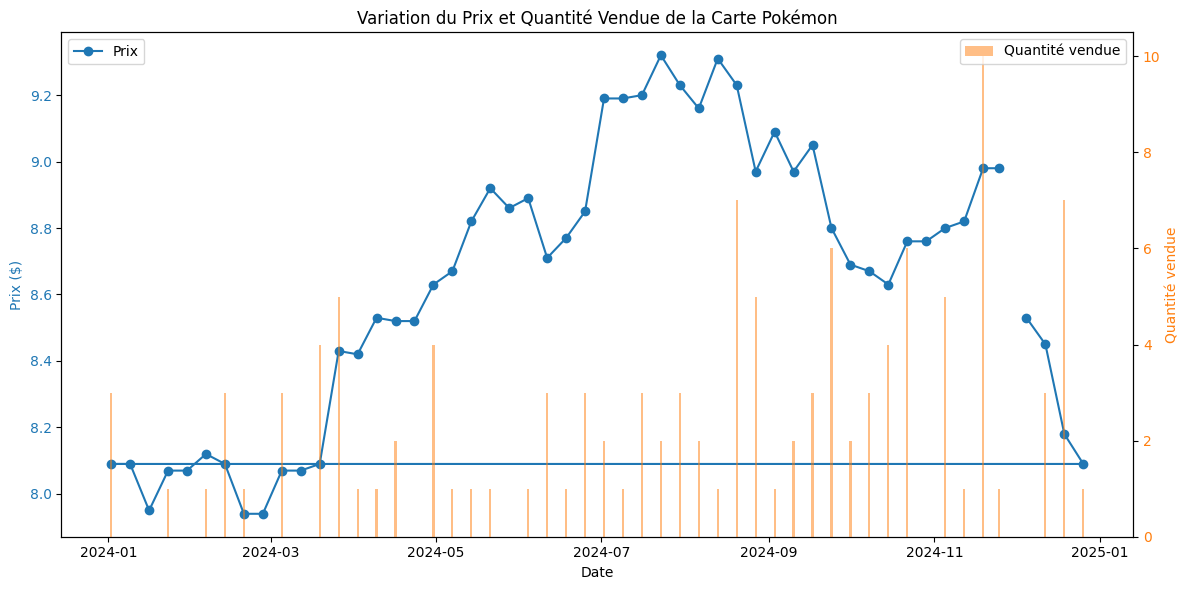

In [28]:
html_content=extract_html_code_1Y(website)
prices=extract_price_history(html_content)
plot_price_quantity_variation(prices)

Page chargée avec succès
Bouton 1Y cliqué avec succès.
Échec : Bouton View More Data non trouvé.
Navigation terminée - Driver fermé.
Échec de l'automatisation.


In [81]:
def extract_price_history_v2(website):
    html_content=extract_html_code_1Y_NM(website)
    soup = BeautifulSoup(html_content, "html.parser")
    price_history = {}
    def convert_date(date_str):
        try:
            start_date, end_date = date_str.split(" to ")
            start_month, start_day = map(int, start_date.split("/"))
            end_month, end_day = map(int, end_date.split("/"))
            
            # Déterminer l'année en fonction de la date
            current_year = 2024
            previous_year = current_year - 1
            
            # Si la date de début est avant le 1er janvier, c'est l'année précédente
            start_year = previous_year if start_month == 12 else current_year
            # Si la date de fin inclut le 1er janvier, c'est la nouvelle année
            end_year = current_year if end_month == 1 else start_year
            
            start_date_obj = datetime(start_year, start_month, start_day)
            end_date_obj = datetime(end_year, end_month, end_day)
            
            return start_date_obj, end_date_obj
            
        except Exception as e:
            print(f"Erreur de conversion de date: {date_str} - {str(e)}")
            return None, None

    # Trouver toutes les lignes du tableau dans le HTML
    rows = soup.find_all("tr")
    
    for row in rows[1:]:  # Skip header row
        cells = row.find_all("td")
        if len(cells) >= 3:
            try:
                date = cells[0].get_text(strip=True)
                price = float(cells[1].get_text(strip=True).replace('$', ''))
                quantity = float(cells[2].get_text(strip=True).replace('$', ''))
                
                start_date_obj, end_date_obj = convert_date(date)
                if start_date_obj and end_date_obj:
                    price_history[(start_date_obj, end_date_obj)] = {
                        'price': price,
                        'quantity_sold': int(quantity)
                    }
            except (ValueError, AttributeError) as e:
                continue

    # Création du DataFrame et tri
    df = pd.DataFrame.from_dict(price_history, orient='index')
    df.index = pd.MultiIndex.from_tuples(df.index, names=['start_date', 'end_date'])
    return df.sort_index()

In [82]:
pricess=extract_price_history_v2(test)

In [83]:
pricess

,,price,quantity_sold
start_date,end_date,,
2023-12-05,2023-12-11,25.18,0
2023-12-12,2023-12-18,25.43,1
2023-12-19,2023-12-25,24.09,5
2023-12-26,2024-01-01,24.11,1
2024-01-02,2024-01-08,23.73,1
2024-01-09,2024-01-15,23.28,4
2024-01-16,2024-01-22,23.59,1
2024-01-23,2024-01-29,23.84,4
2024-01-30,2024-02-05,23.74,2


In [103]:
def plot_price_quantity_variation(df):
    # Création de la figure et des axes
    fig, ax1 = plt.subplots(figsize=(15, 7))
    
    # Configuration de l'axe des prix (gauche)
    ax1.set_xlabel('Date de début')
    ax1.set_ylabel('Prix ($)', color='blue')
    ax1.plot(df.index.get_level_values('start_date'), df['price'], 
             color='blue', marker='o', linewidth=1.5, label='Prix', markersize=4)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Ajout de la ligne moyenne des prix
    mean_price = df['price'].mean()
    ax1.axhline(y=mean_price, color='blue', linestyle='--', alpha=0.3, 
                label=f'Prix moyen: ${mean_price:.2f}')
    
    # Configuration de l'axe des quantités (droite)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Quantité vendue', color='orange')
    ax2.bar(df.index.get_level_values('start_date'), df['quantity_sold'], 
            color='orange', alpha=0.3, label='Quantité vendue')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Rotation des dates pour meilleure lisibilité
    plt.xticks(rotation=45, ha='right')
    
    # Titre
    plt.title('Évolution du Prix et des Ventes de la Carte Pokémon')
    
    # Légendes combinées
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Ajustement de la mise en page
    plt.tight_layout()
    
    return fig, (ax1, ax2)

(<Figure size 1500x700 with 2 Axes>,
 (<Axes: xlabel='Date de début', ylabel='Prix ($)'>,
  <Axes: title={'center': 'Évolution du Prix et des Ventes de la Carte Pokémon'}, ylabel='Quantité vendue'>))

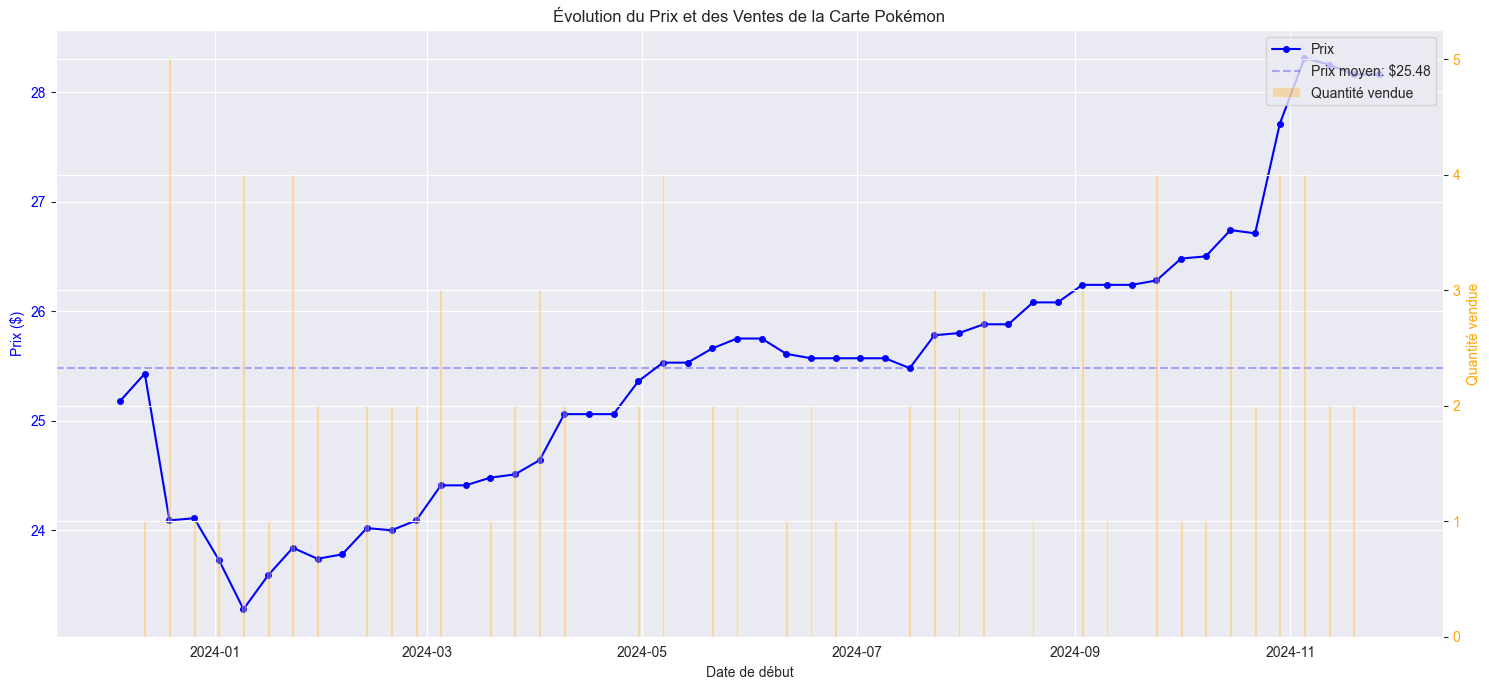

In [104]:
plot_price_quantity_variation(pricess)

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

def plot_price_quantity_variation_advanced(df):
    # Configuration du style
    sns.set_style("darkgrid")
    sns.set_palette("husl")
    
    # Création de la figure avec une taille spécifique
    fig = plt.figure(figsize=(15, 10))
    
    # Création du layout avec gridspec
    gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)
    
    # Premier subplot pour les prix
    ax1 = plt.subplot(gs[0])
    
    # Tracer la ligne des prix avec une zone ombrée
    sns.lineplot(data=df, x=df.index.get_level_values('start_date'), 
                y='price', ax=ax1, color='#4C72B0', linewidth=2)
    ax1.fill_between(df.index.get_level_values('start_date'), 
                     df['price'].min(), df['price'], alpha=0.2)
    
    # Ajout de la moyenne mobile sur 7 périodes
    rolling_mean = df['price'].rolling(window=7).mean()
    ax1.plot(df.index.get_level_values('start_date'), rolling_mean, 
             '--', color='red', label='Moyenne mobile (7 périodes)')
    
    # Personnalisation du premier subplot
    ax1.set_title('Évolution du Prix de la Carte Pokémon', pad=20, fontsize=14)
    ax1.set_xlabel('')
    ax1.set_ylabel('Prix ($)', fontsize=12)
    ax1.legend()
    
    # Second subplot pour les quantités
    ax2 = plt.subplot(gs[1])
    
    # Création d'un barplot avec seaborn
    sns.barplot(x=df.index.get_level_values('start_date'), 
               y='quantity_sold', data=df, ax=ax2, 
               color='#FFA500', alpha=0.6)
    
    # Personnalisation du second subplot
    ax2.set_title('Volume des Ventes', fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Quantité vendue', fontsize=12)
    
    # Rotation des dates pour les deux subplots
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', rotation=45)
        
    # Ajout d'annotations statistiques
    stats_text = f"""
    Prix moyen: ${df['price'].mean():.2f}
    Prix max: ${df['price'].max():.2f}
    Prix min: ${df['price'].min():.2f}
    Total vendu: {df['quantity_sold'].sum()} unités
    """
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    return fig, (ax1, ax2)

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_58384/1531245320.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1500x1000 with 2 Axes>,
 (<Axes: title={'center': 'Évolution du Prix de la Carte Pokémon'}, ylabel='Prix ($)'>,
  <Axes: title={'center': 'Volume des Ventes'}, xlabel='Date', ylabel='Quantité vendue'>))

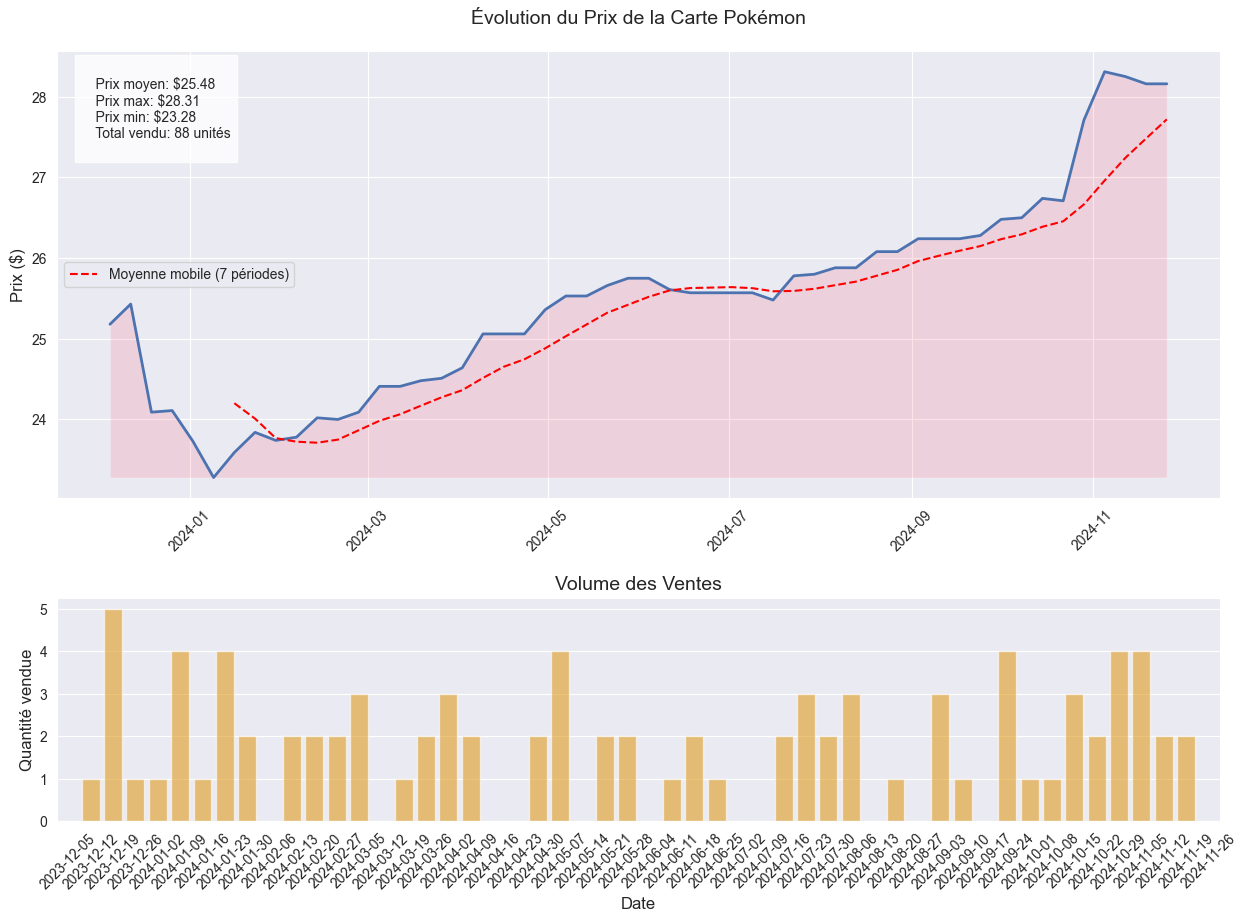

In [102]:
plot_price_quantity_variation_advanced(pricess)